<a href="https://colab.research.google.com/github/NaufalFikriansyah/Breast_Cancer_Detection/blob/main/Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [63]:
# importing libraries
import numpy as np
import cv2
import os 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [64]:
import re
import numpy as np 
import pandas as pd
import random
import math
import cv2 
import seaborn as sns
from glob import glob
import os
from pathlib import Path
import itertools
import tensorflow as tf

In [65]:
import re
import numpy as np 
import pandas as pd
import random
import math
import cv2 
import seaborn as sns
from glob import glob
import os
from pathlib import Path
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input,LeakyReLU,BatchNormalization,Dropout
from tensorflow.nn import atrous_conv2d
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim,mean_squared_error as mse
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
os.listdir(r"/content/drive/MyDrive/Dataset/Dataset_BUSI_with_GT")

['normal', 'malignant', 'benign']

In [68]:
#global_path = 'C:/Users/lenovo/Downloads/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*.png' 
path = '/content/drive/MyDrive/Dataset/Dataset_BUSI_with_GT/*/*.png' 
image_path = glob(path)
image_path.sort()
print(len(image_path))

1578


In [69]:
# create a dictionary to store images grouped by label
images_with_class = {}
classes={'benign':0,'malignant':1,'normal':2}
output=[]
for label in classes.keys():
    address = '/content/drive/MyDrive/Dataset/Dataset_BUSI_with_GT/'+label
    for image_name in os.listdir(address):
        if label not in images_with_class.keys():
            images_with_class[label] = {'Original_Image':[],'Mask_Image':[]}
        output.append(classes[label])
        if 'mask' in image_name:
            mask_image = cv2.imread(address+'/'+image_name)
            mask_image = cv2.resize(mask_image, (128,128))
            images_with_class[label]['Mask_Image'].append(mask_image)
        else:
            original_image = cv2.imread(address+'/'+image_name)
            original_image = cv2.resize(original_image, (128,128))
            images_with_class[label]['Original_Image'].append(original_image)


In [70]:
# Number of images per class
labels = []
for keys,values in images_with_class.items():
    #print(value)
    for key,value in values.items():
        (labels.extend([key]*len(value)))
  
        print("{0} : {1} : {2} ".format(keys,key, len(value)))

benign : Original_Image : 437 
benign : Mask_Image : 454 
malignant : Original_Image : 210 
malignant : Mask_Image : 211 
normal : Original_Image : 133 
normal : Mask_Image : 133 


Text(0.5, 1.0, 'Masked_Image')

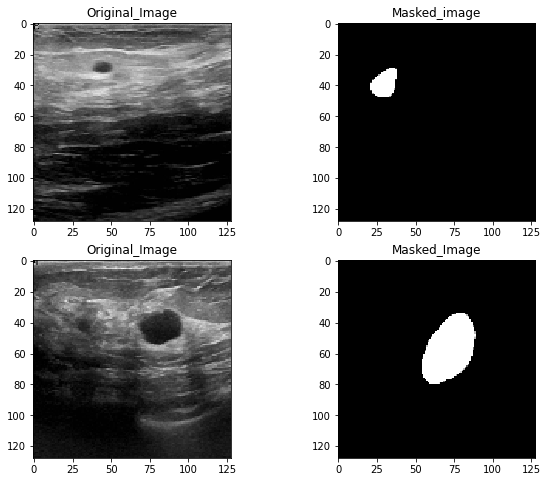

In [71]:
fig,axis = plt.subplots(2,2)
axis[0,0].imshow(images_with_class['benign']['Original_Image'][50])
axis[0,0].set_title('Original_Image')
axis[0,1].imshow(images_with_class['benign']['Mask_Image'][50])
axis[0,1].set_title('Masked_image')
axis[1,0].imshow(images_with_class['benign']['Original_Image'][100])
axis[1,0].set_title('Original_Image')
axis[1,1].imshow(images_with_class['benign']['Mask_Image'][100])
axis[1,1].set_title('Masked_Image')

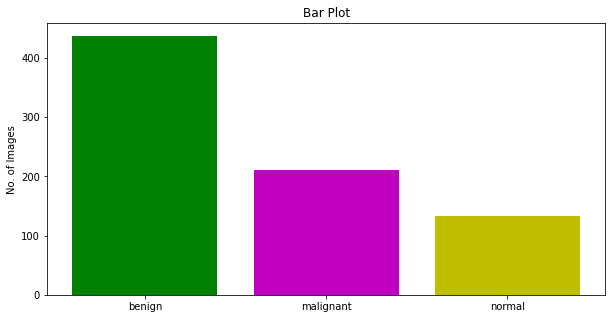

In [72]:
fig = plt.figure(figsize = (10, 5))
plt.bar(list(images_with_class.keys()),[len(images_with_class[key]['Original_Image']) for key in images_with_class.keys()], color = ['g','m','y'])
plt.ylabel("No. of Images")
plt.title("Bar Plot") 
plt.show()


In [73]:
## function to plot sample images
def sample_images(images,gray = False):
    figure, axes = plt.subplots(1, 4)
    figure.set_size_inches(35,25)
    axes[0].imshow(images[1],cmap='gray') if gray else axes[0].imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
    axes[0].title.set_text("Benign")
    axes[0].axis('off')
    axes[1].imshow(images[55],cmap='gray') if gray else axes[1].imshow(cv2.cvtColor(images[55], cv2.COLOR_BGR2RGB))
    axes[1].title.set_text("Benign")
    axes[1].axis('off')
    axes[2].imshow(images[450],cmap='gray') if gray else axes[2].imshow(cv2.cvtColor(images[450], cv2.COLOR_BGR2RGB))
    axes[2].axis('off')
    axes[2].title.set_text("Malignant")
    axes[3].imshow(images[451],cmap='gray') if gray else axes[3].imshow(cv2.cvtColor(images[451], cv2.COLOR_BGR2RGB))
    axes[3].axis('off')
    axes[3].title.set_text("Malignant")
    plt.show()

In [74]:
# function to find the histogram of images
def hist(I):       #2D
    if len(I.shape)>2:
        I=cv2.cvtColor(I,cv2.COLOR_BGR2GRAY)
    H=np.zeros((256,1))
    for x in np.nditer(I):
        if x>255:
            x=255
        elif x<0:
            x=0
        H[int(x)]=H[int(x)]+1
    return H

In [75]:
a = images_with_class['benign']['Original_Image'] 
b = images_with_class['malignant']['Original_Image']
c = images_with_class['normal']['Original_Image']

d = images_with_class['benign']['Mask_Image'] 
e = images_with_class['malignant']['Mask_Image']
f = images_with_class['normal']['Mask_Image']

In [76]:
input_images = a+b+c+d+e+f 
print(np.array(input_images).shape)
print(input_images[10].dtype)


(1578, 128, 128, 3)
uint8


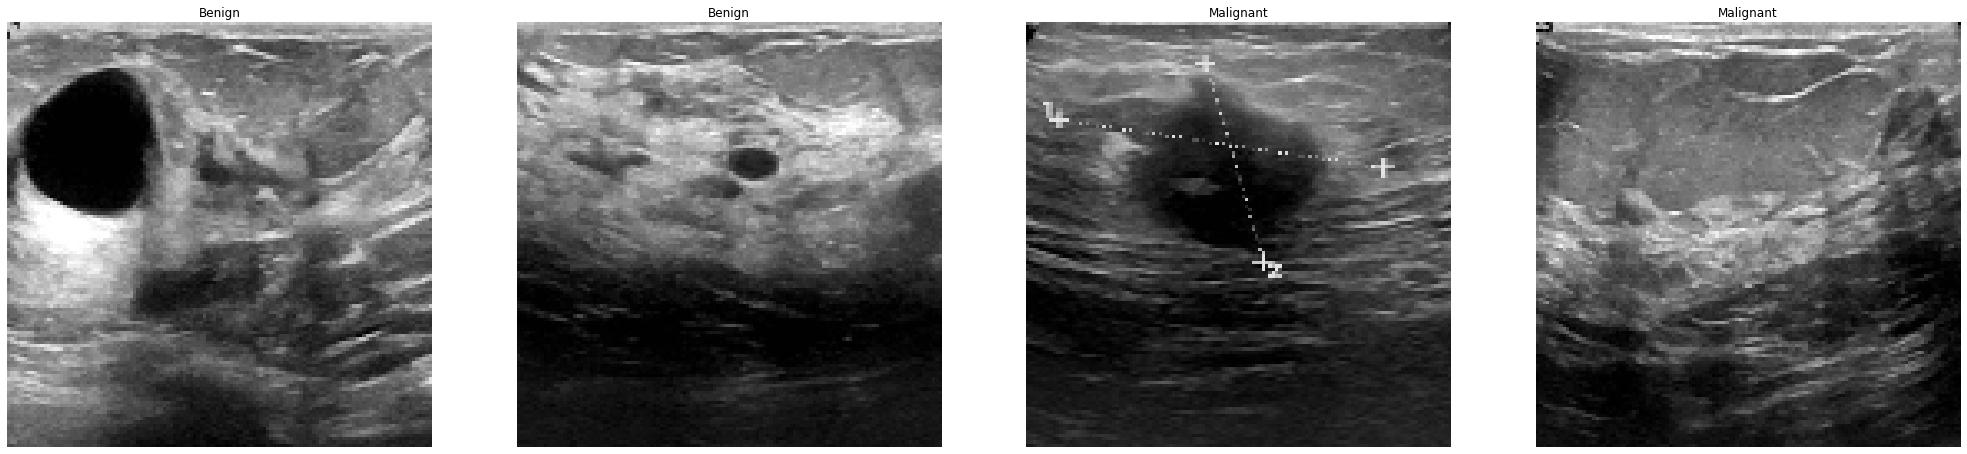

In [77]:
## plot the sample images
sample_images(input_images)

## Image Preprocessing

### Grayscale Image

1578


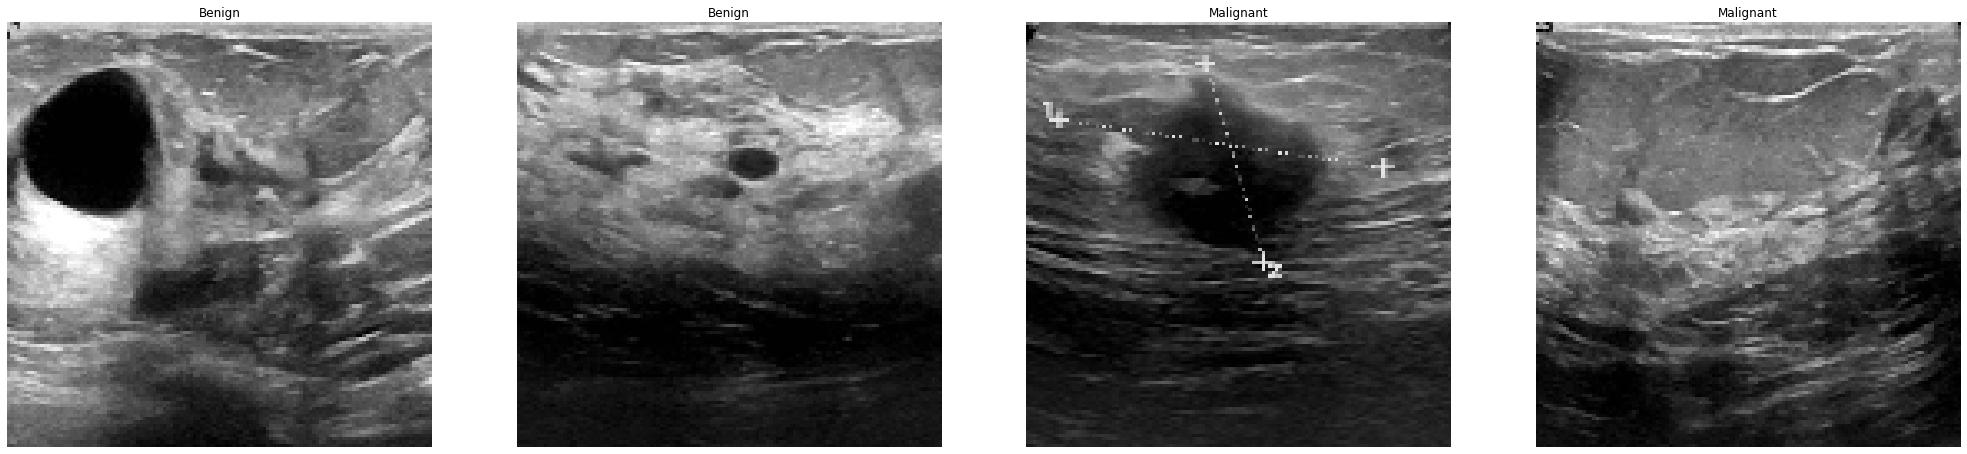

In [78]:
# convert the RBG images to gray scale images
grayscale_images = []
grayscale_images.clear()
for idx, image in enumerate(input_images,1):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale_images.append(gray_image)
print(idx)    
sample_images(grayscale_images)

Text(0.5, 1.0, 'histogram for malignant')

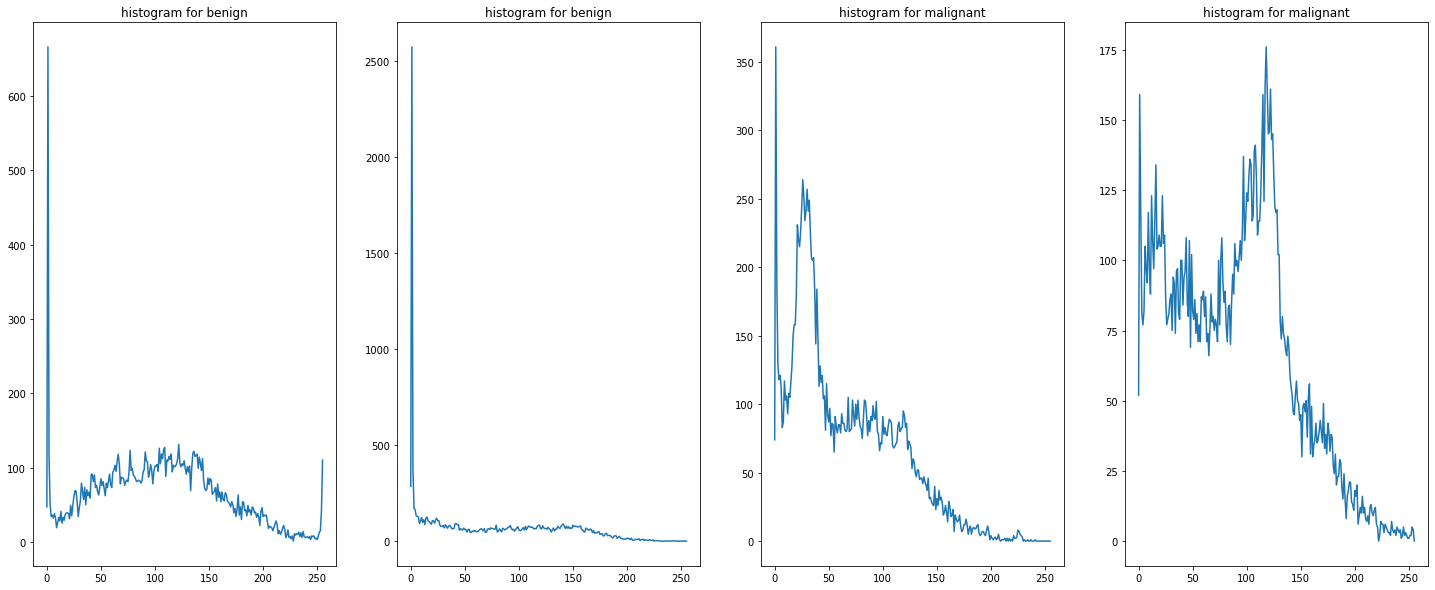

In [79]:
## plot for histogram equalization
fig = plt.figure(figsize=[25,10])
plt.subplot(1,4,1)
plt.plot(hist(grayscale_images[1]))
plt.title('histogram for benign')
plt.subplot(1,4,2)
plt.plot(hist(grayscale_images[50]))
plt.title('histogram for benign')
plt.subplot(1,4,3)
plt.plot(hist(grayscale_images[450]))
plt.title('histogram for malignant')
plt.subplot(1,4,4)
plt.plot(hist(grayscale_images[451]))
plt.title('histogram for malignant')

### Histogram Equalization

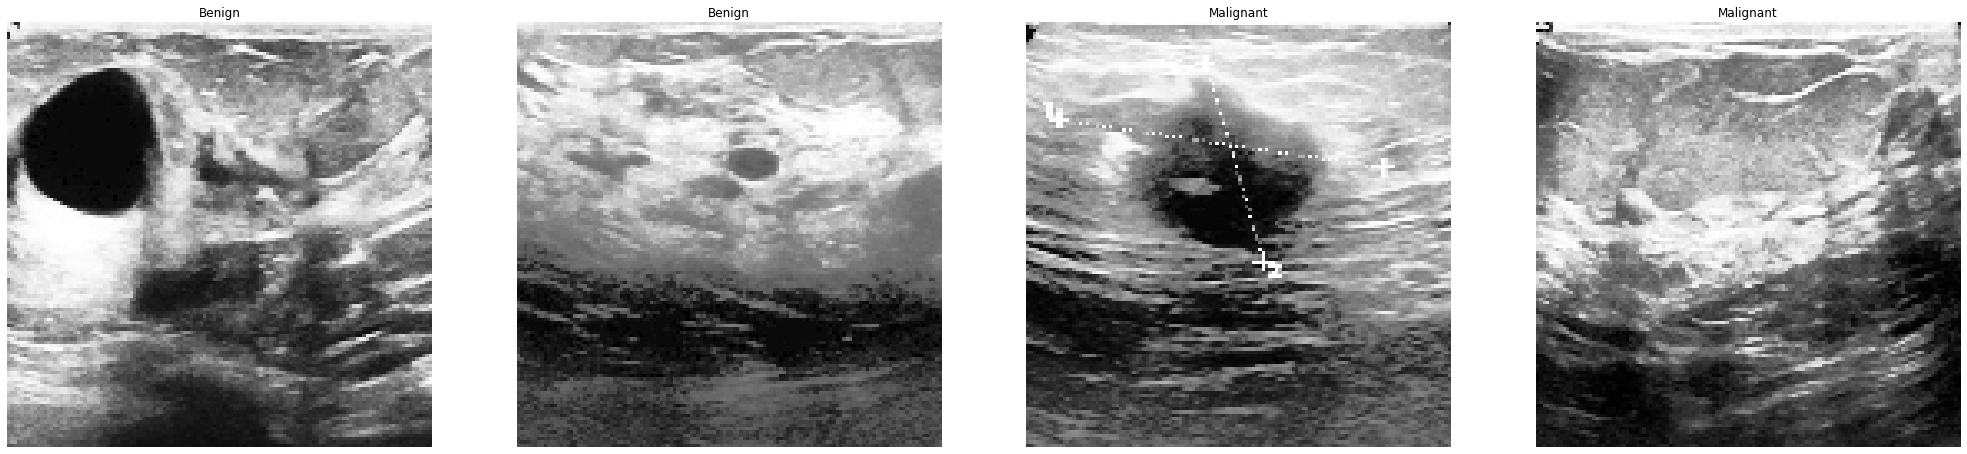

In [80]:
# histogram equalization on gray scale images
eqhist_images=[]
eqhist_images.clear()
for idx, image in enumerate(grayscale_images):
    eqhistimage = cv2.equalizeHist(image)
    eqhist_images.append(eqhistimage)
sample_images(eqhist_images, True)

Text(0.5, 1.0, 'histogram for malignant')

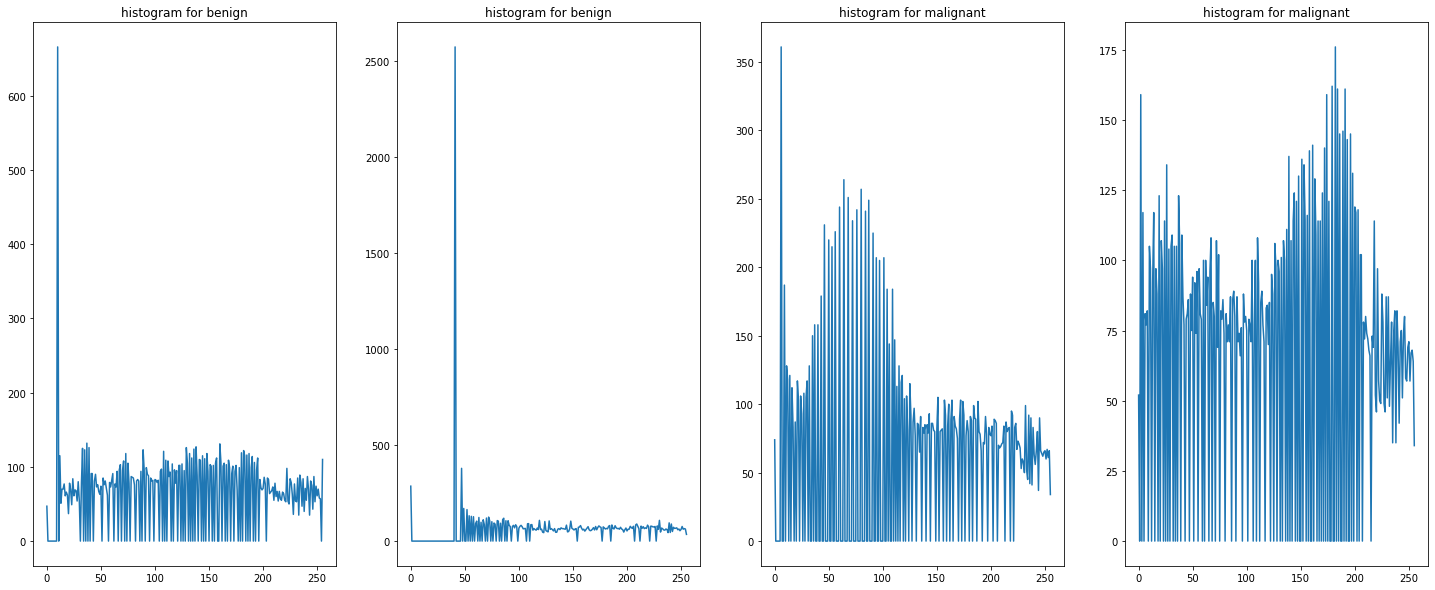

In [81]:
# plot the histogram after histogram operation
fig = plt.figure(figsize=[25,10])
plt.subplot(1,4,1)
plt.plot(hist(eqhist_images[1]))
plt.title('histogram for benign')
plt.subplot(1,4,2)
plt.plot(hist(eqhist_images[50]))
plt.title('histogram for benign')
plt.subplot(1,4,3)
plt.plot(hist(eqhist_images[450]))
plt.title('histogram for malignant')
plt.subplot(1,4,4)
plt.plot(hist(eqhist_images[451]))
plt.title('histogram for malignant')

### Bilateral Filter

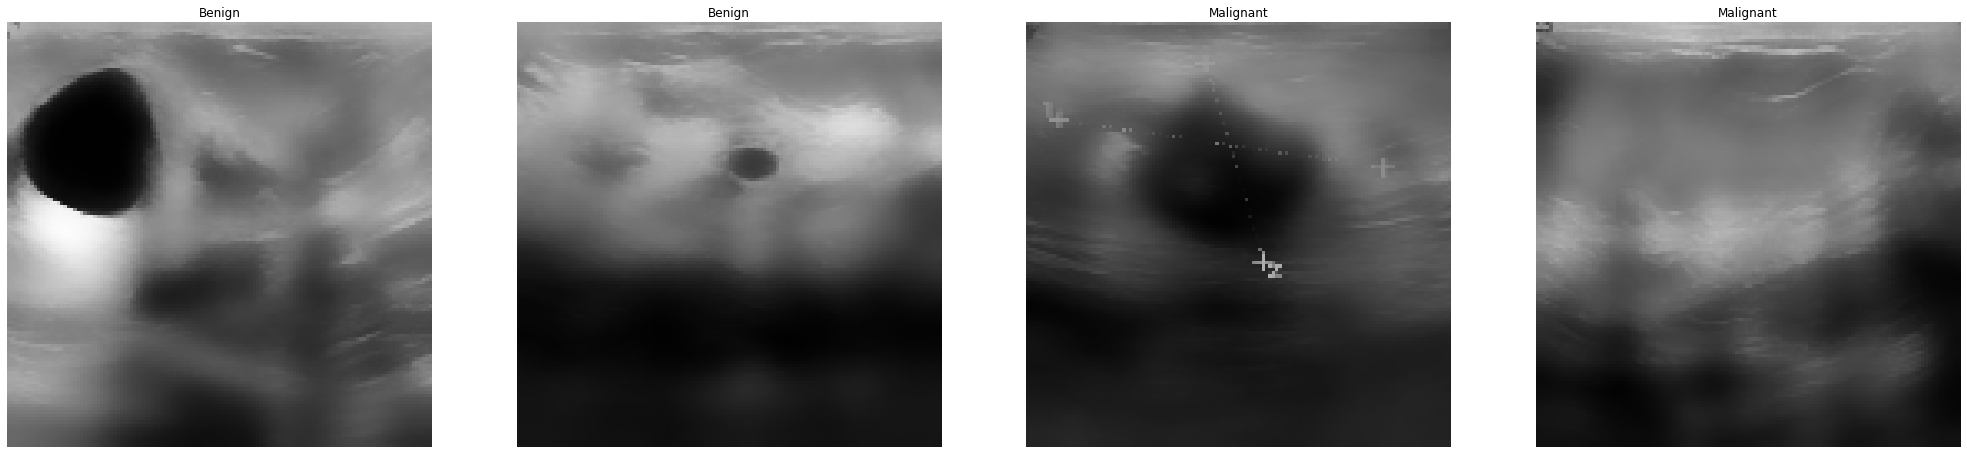

In [82]:
## Applying bilateral filter on grayscale images
bilateral_images = []
bilateral_images.clear()
for idx, image in enumerate(grayscale_images):
    bilateral = cv2.bilateralFilter(image, 15, 75, 75)
    bilateral_images.append(bilateral)
sample_images(bilateral_images)

Text(0.5, 1.0, 'histogram for malignant')

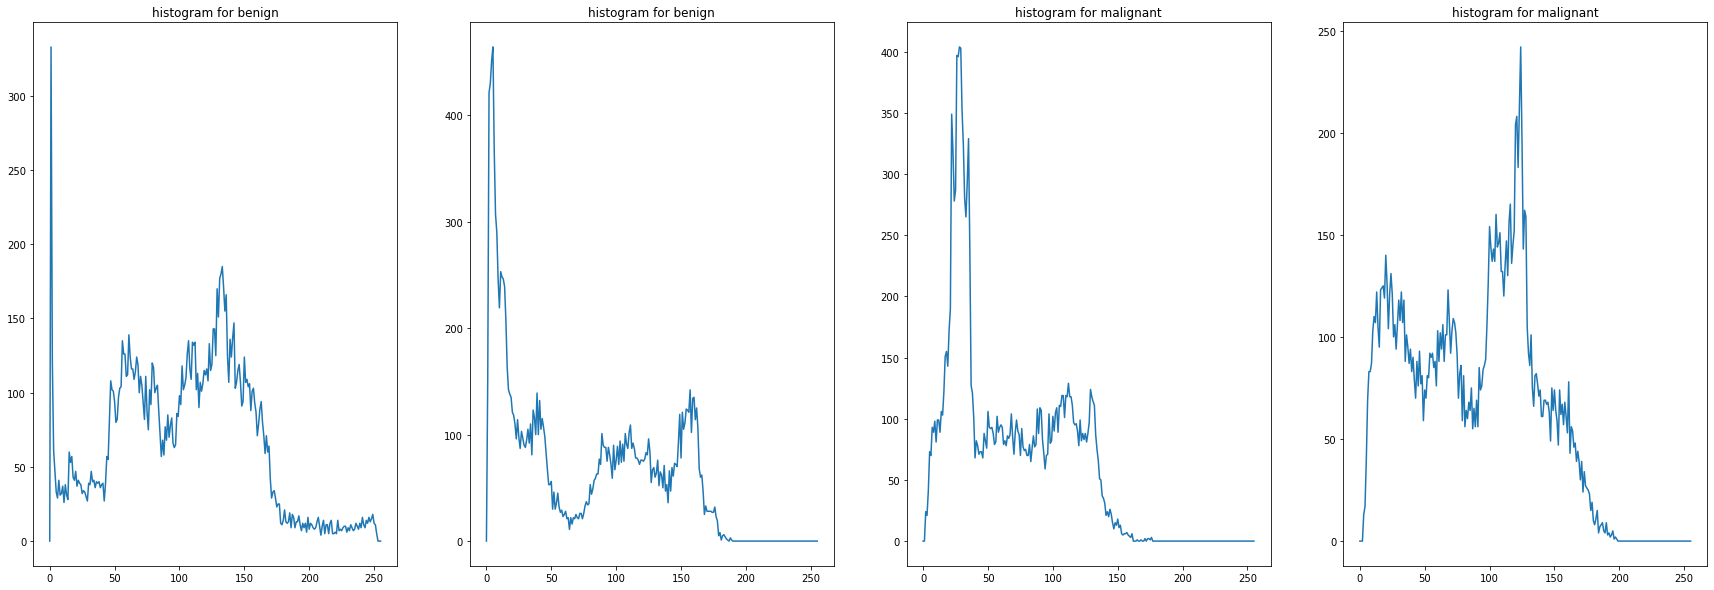

In [83]:
## plot the histogram of bilateral filter
fig = plt.figure(figsize=[30,10])
plt.subplot(1,4,1)
plt.plot(hist(bilateral_images[1]))
plt.title('histogram for benign')
plt.subplot(1,4,2)
plt.plot(hist(bilateral_images[50]))
plt.title('histogram for benign')
plt.subplot(1,4,3)
plt.plot(hist(bilateral_images[450]))
plt.title('histogram for malignant')
plt.subplot(1,4,4)
plt.plot(hist(bilateral_images[451]))
plt.title('histogram for malignant')

### CLAHE

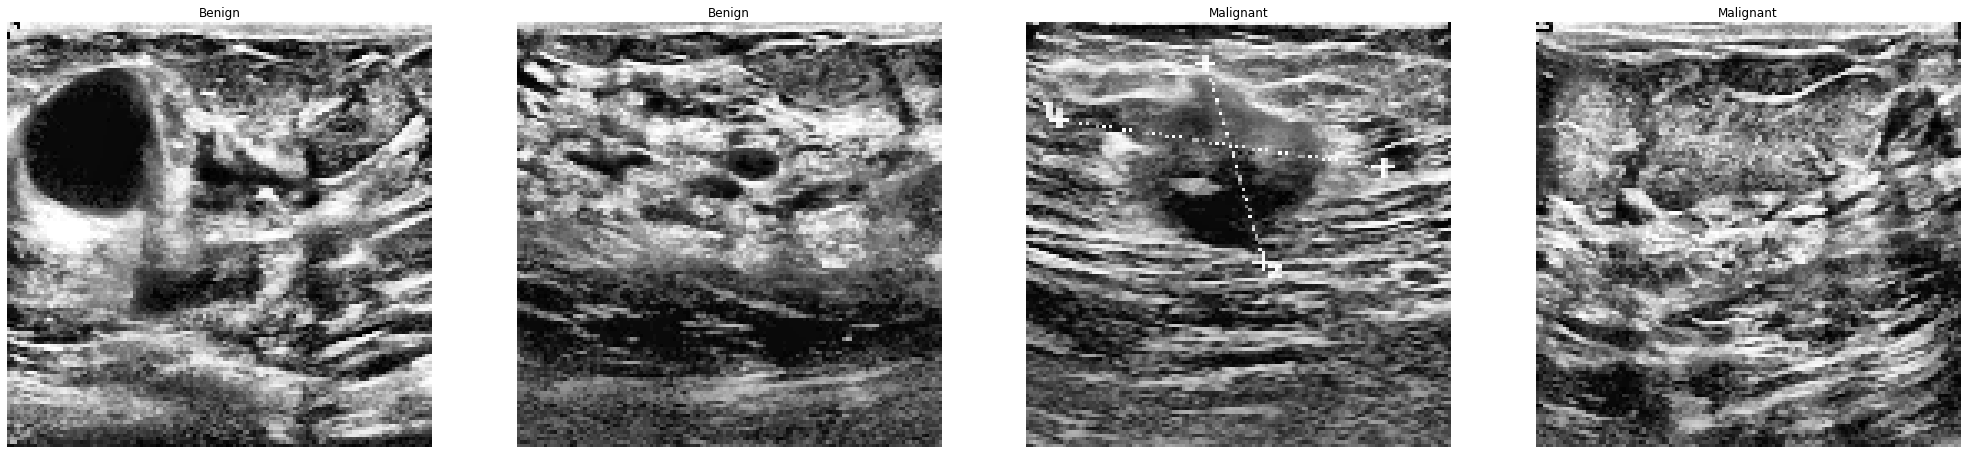

In [84]:
# applying clahe on grayscale images
Clahe_images=[]
Clahe_images.clear()
for idx, image in enumerate(grayscale_images):
    #R, G, B = cv2.split(image)
    
    clahe = cv2.createCLAHE(clipLimit = 5)
    clahe_img = clahe.apply(image) 
    Clahe_images.append(clahe_img)
sample_images(Clahe_images, True)

Text(0.5, 1.0, 'histogram for malignant')

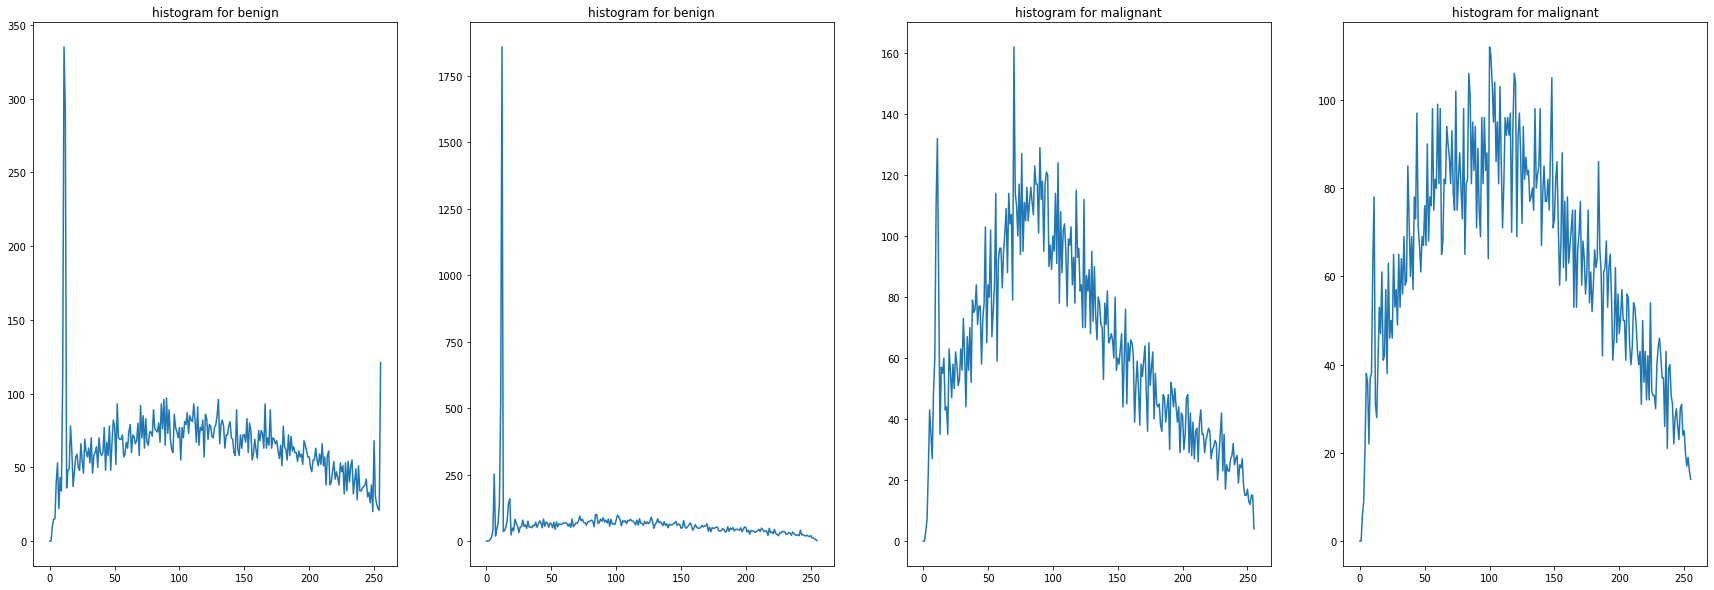

In [85]:
# plot the histogram after clahe operation
fig = plt.figure(figsize=[30,10])
plt.subplot(1,4,1)
plt.plot(hist(Clahe_images[1]))
plt.title('histogram for benign')
plt.subplot(1,4,2)
plt.plot(hist(Clahe_images[50]))
plt.title('histogram for benign')
plt.subplot(1,4,3)
plt.plot(hist(Clahe_images[450]))
plt.title('histogram for malignant')
plt.subplot(1,4,4)
plt.plot(hist(Clahe_images[451]))
plt.title('histogram for malignant')

### Otsu Binarization

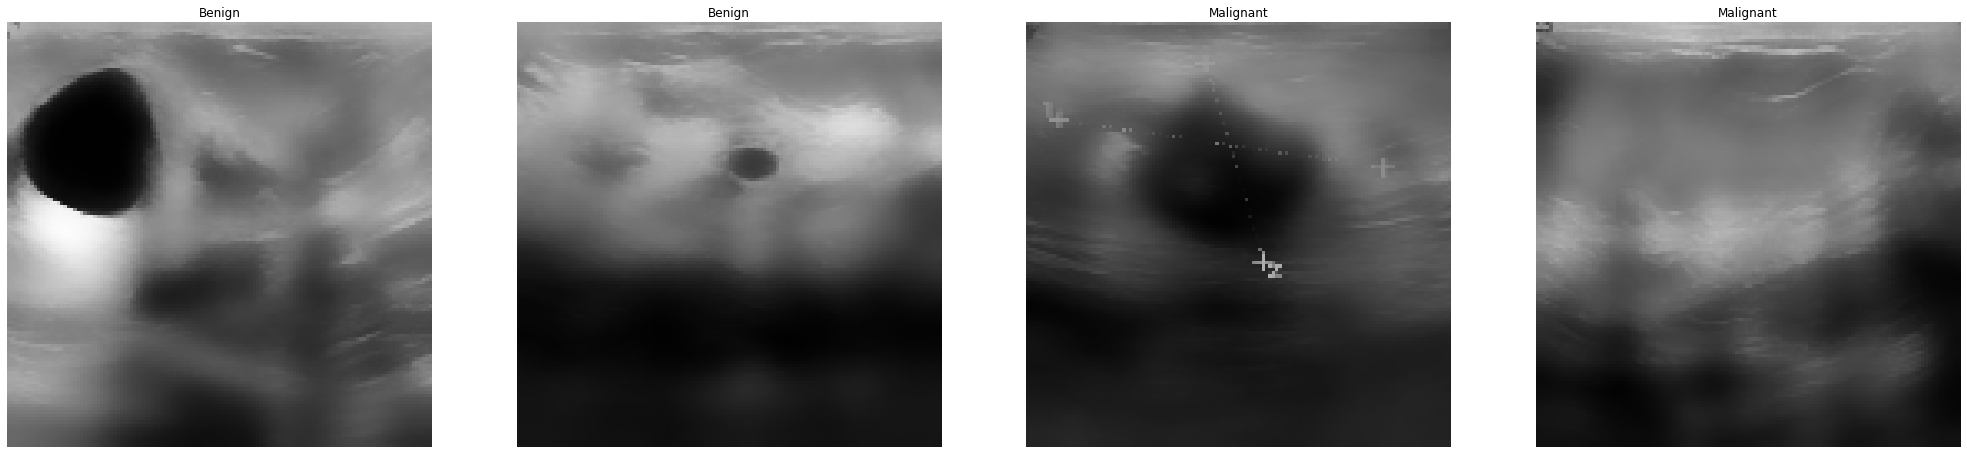

In [86]:
thresholded=[]
thresholded.clear()
for image in bilateral_images:
    thresh, binaryImg = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
    ret, image = cv2.threshold(image,thresh-20,255,cv2.THRESH_TOZERO)
    thresholded.append(image)
#(np.array(thresholded)).shape
sample_images(thresholded)


### Adaptive_Threshold¶

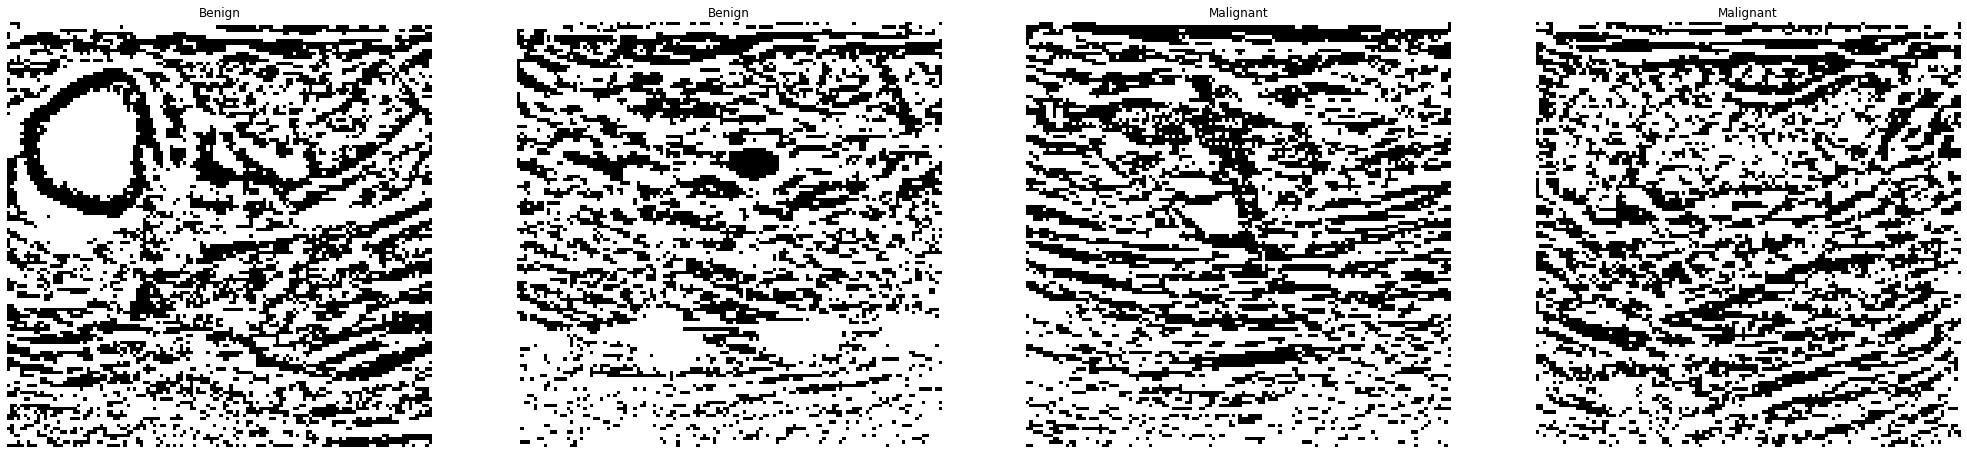

In [87]:
# Applied threshold to zero inversion
thresholded_images=[]
thresholded_images.clear()
for idx, image in enumerate(grayscale_images):
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
    thresholded_images.append(image)
sample_images(thresholded_images, True)

## Edge Detection

### Sobel Edge Detection

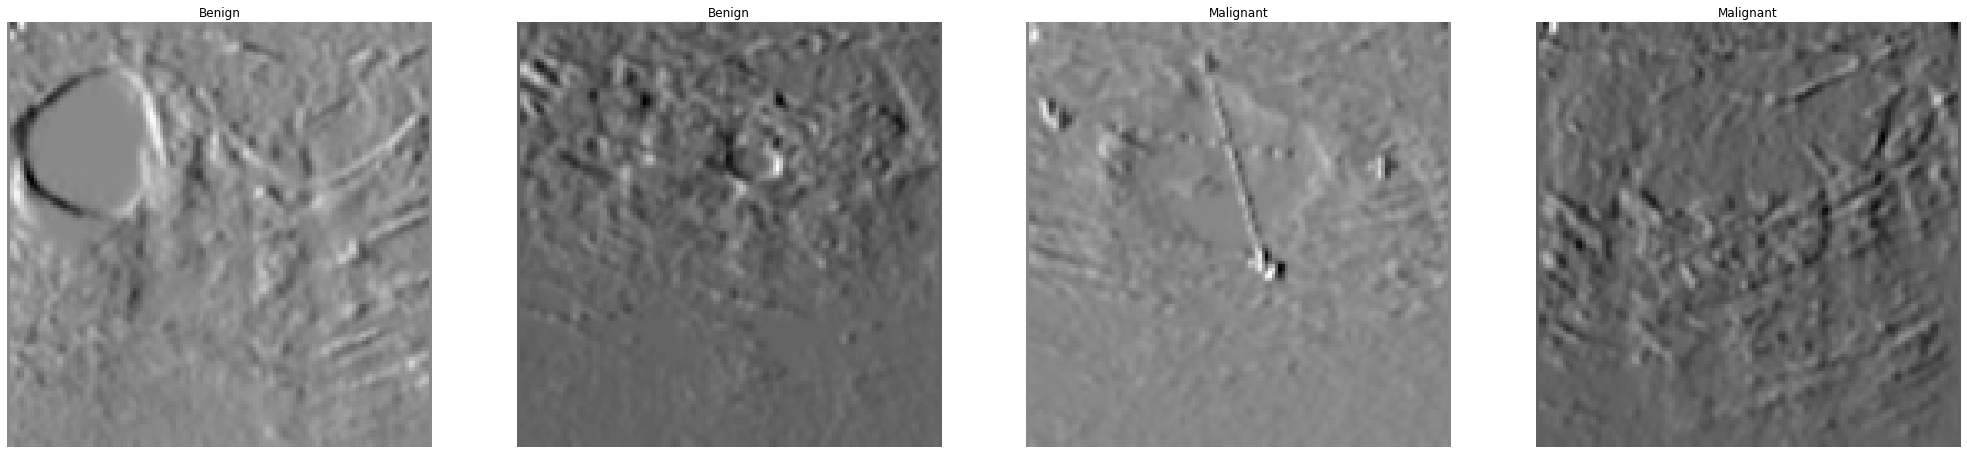

In [88]:
# Using sobel filter on grayscale images
x_edged_images=[]
x_edged_images.clear()
for idx, image in enumerate(grayscale_images):
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    x_edged_images.append(sobelx)
sample_images(x_edged_images, True)

### Conny Edge Detection

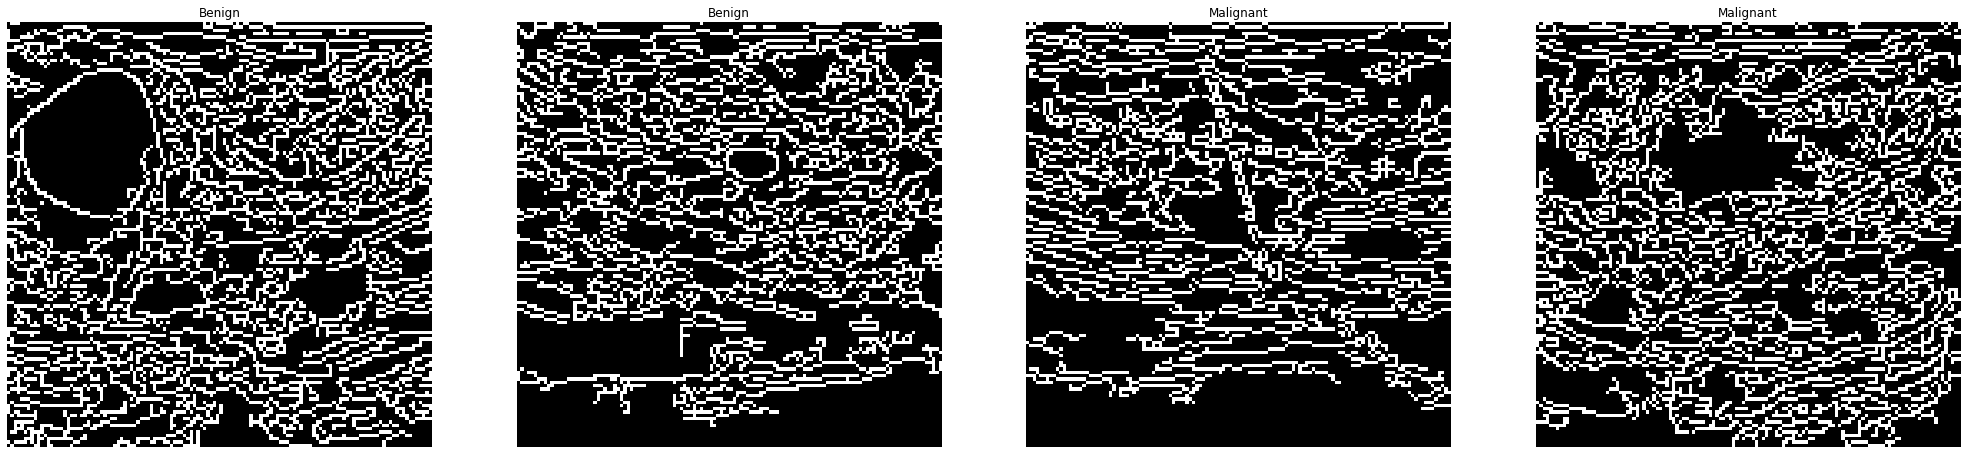

In [89]:
conny_edged_images=[]
conny_edged_images.clear()
for idx, image in enumerate(input_images):
    image = cv2.Canny(image,10,200)
    conny_edged_images.append(image)
sample_images(conny_edged_images, True)

## Morphological Operations

### Erosion

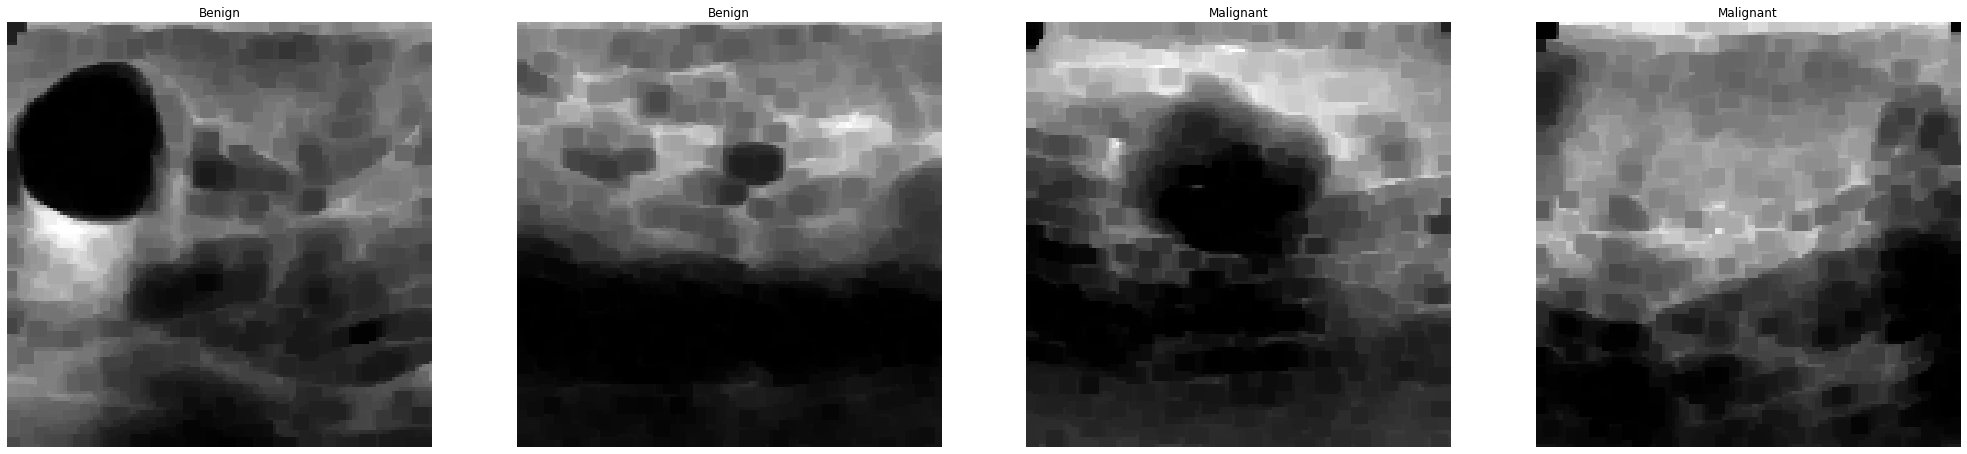

In [90]:
ero_images = []
ero_images.clear()
kernel = np.ones((5,5),np.uint8)
for idx, image in enumerate(grayscale_images):
    
    erosion = cv2.erode(image,kernel,iterations = 1)
    ero_images.append(erosion)
sample_images(ero_images, True)

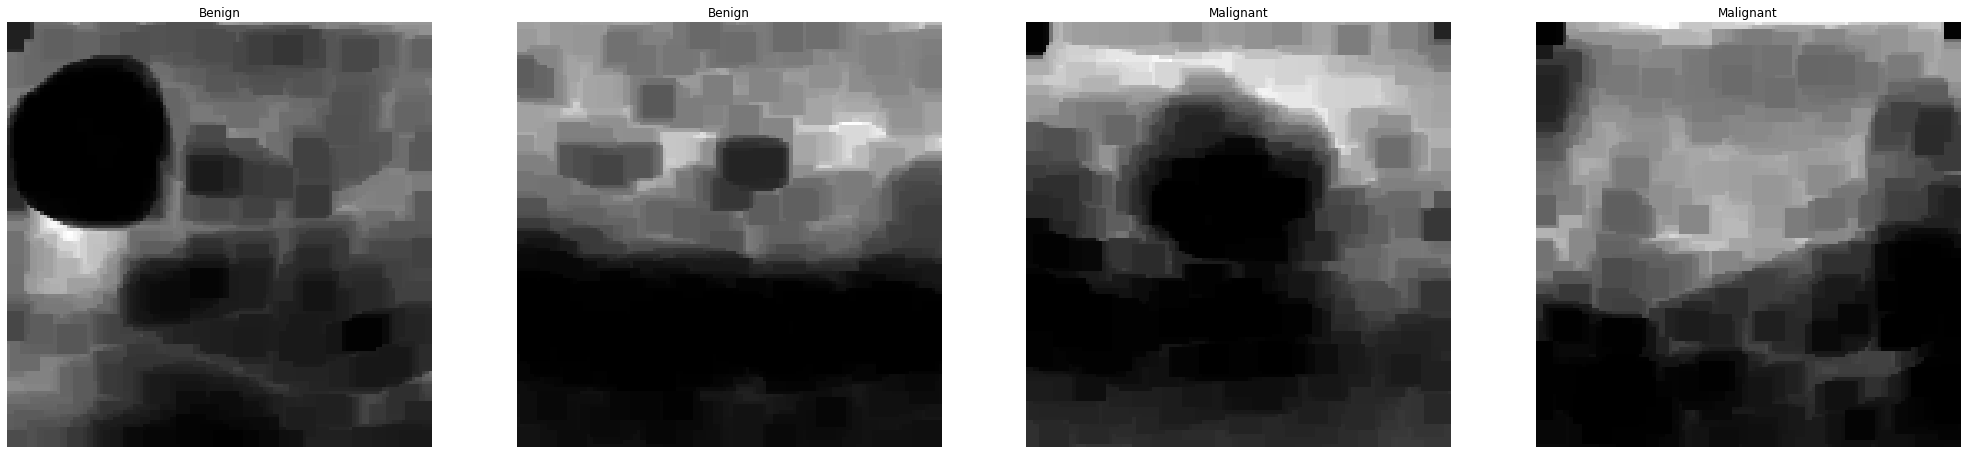

In [91]:
ero_images = []
ero_images.clear()
kernel = np.ones((3,3),np.uint8)
for idx, image in enumerate(grayscale_images):
    
    erosion = cv2.erode(image,kernel,iterations = 2)
    dilation = cv2.dilate(erosion,kernel,iterations = 1)
    erosion = cv2.erode(dilation,kernel,iterations = 2)
    dilation = cv2.dilate(erosion,kernel,iterations = 1)
    erosion = cv2.erode(dilation,kernel,iterations = 2)
    ero_images.append(erosion)
sample_images(ero_images, True)

## Dilation

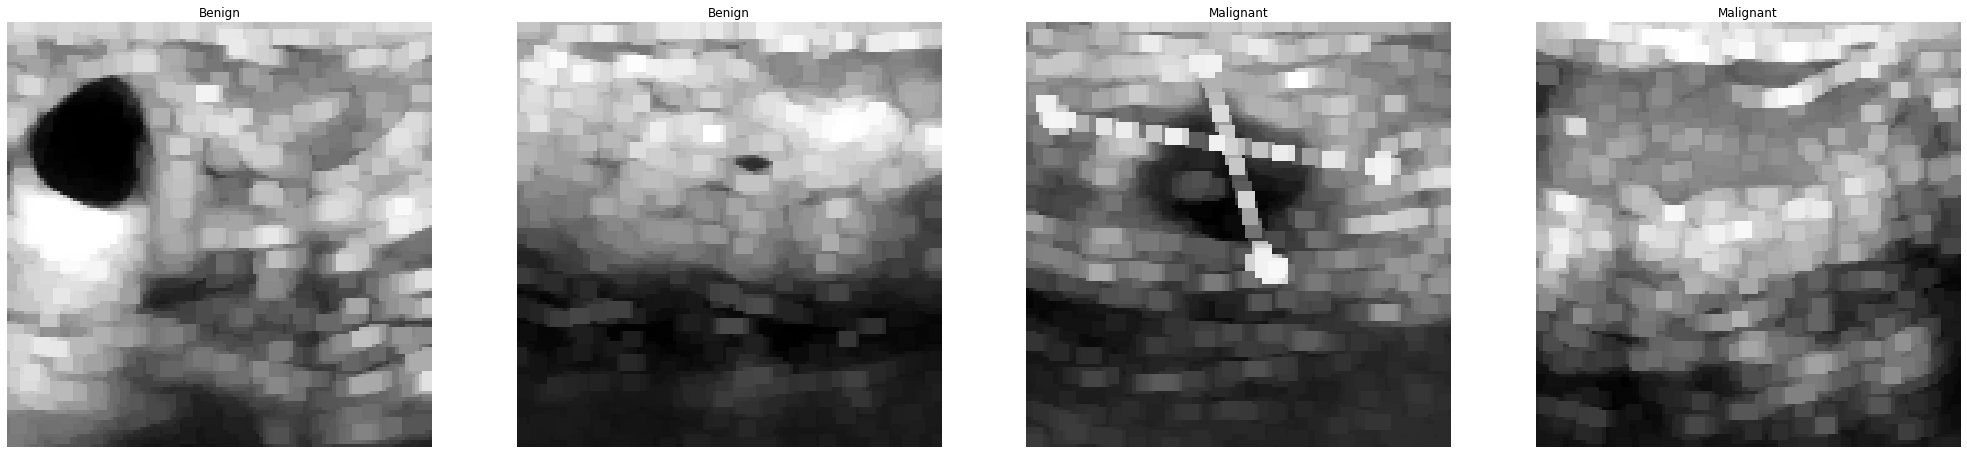

In [92]:
dilation_images = []
dilation_images.clear()
kernel = np.ones((5,5),np.uint8)
for idx, image in enumerate(grayscale_images):
    dilation = cv2.dilate(image,kernel,iterations = 1)
    dilation_images.append(dilation)
sample_images(dilation_images, True)

## Calculation Statistical and GLCM Features

In [93]:
# calculating the GLCM features
Energy = [];Correlation = [];Dissimilarity = [];Homogenity = [];Contrast = [];Entropy = []

from skimage.feature import greycomatrix, greycoprops
def energy(img):
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return greycoprops(GLCM, 'energy')[0]
def correlation(img):
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])      
            return greycoprops(GLCM, 'correlation')[0]
def dissimilarity(img):
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return  greycoprops(GLCM, 'dissimilarity')[0]
def homogenity(img):
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])       
            return  greycoprops(GLCM, 'homogeneity')[0]
def contrast(img):
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])   
            return greycoprops(GLCM, 'contrast')[0]
def entropy(img):
            img = np.array(img)
            GLCM = greycomatrix(img, [1], [0])   
            return greycoprops(GLCM, 'entropy')[0]        
for img in input_images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Energy.append(energy(img)[0])
    Correlation.append(correlation(img)[0])
    Dissimilarity.append(dissimilarity(img)[0])
    Homogenity.append(homogenity(img)[0])
    Contrast.append(contrast(img)[0])
    Entropy.append(contrast(img)[0]) 

In [94]:
## mean and standard deviation of grayscale images
gray_mean=[]
gray_std_dev=[]
gray_mean.clear()
gray_std_dev.clear()
for idx, image in enumerate(grayscale_images):
    mean = np.mean(image)
    std_dev = np.std(image)
    gray_mean.append(mean)
    gray_std_dev.append(std_dev)

In [95]:
## calculating mean and standard deviation of histogram equalization images
Histeq_mean=[]
Histeq_std=[]
Histeq_mean.clear()
Histeq_std.clear()
for image in eqhist_images:
    Histeq_mean.append(np.mean(image))
    Histeq_std.append(np.std(image))

In [96]:
## mean and standard deviation of clahe images
clahe_mean=[]
clahe_std_dev=[]
clahe_mean.clear()
clahe_std_dev.clear()
for idx, image in enumerate(Clahe_images):
    mean = np.mean(image)
    std_dev = np.std(image)
    clahe_mean.append(mean)
    clahe_std_dev.append(std_dev)

In [97]:
## mean and standard deviation of adative histogram equalization images
adaptive_mean=[]
adaptive_std_dev=[]
adaptive_mean.clear()
adaptive_std_dev.clear()
for idx, image in enumerate(thresholded):
    mean = np.mean(image)
    std_dev = np.std(image)
    adaptive_mean.append(mean)
    adaptive_std_dev.append(std_dev)

In [98]:
## mean and standard deviation of clahe images
sobel_mean=[]
sobel_std_dev=[]
sobel_mean.clear()
sobel_std_dev.clear()
for idx, image in enumerate(x_edged_images):
    mean = np.mean(image)
    std_dev = np.std(image)
    sobel_mean.append(mean)
    sobel_std_dev.append(std_dev)

In [99]:
## calculating mean and standard deviation of erosed images 
er_mean=[]
er_std_dev=[]
er_mean.clear()
er_std_dev.clear()
for idx, image in enumerate(ero_images):
    mean = np.mean(image)
    std_dev = np.std(image)
    er_mean.append(mean)
    er_std_dev.append(std_dev)

In [100]:
# calculating the mean and standard deviation of dilated images
dl_mean=[]
dl_mean.clear()
dl_std_dev=[]
dl_std_dev.clear()
for idx, image in enumerate(dilation_images):
    mean = np.mean(image)
    std_dev = np.std(image) 
    dl_mean.append(mean)
    dl_std_dev.append(std_dev)

In [101]:
a = pd.DataFrame({'gray_mean':gray_mean})
b = pd.DataFrame({'gray_std_dev':gray_std_dev})
c = pd.DataFrame({'adaptive_mean':adaptive_mean})
d = pd.DataFrame({'adaptive_std_dev':adaptive_std_dev})
e = pd.DataFrame({'clahe_mean':clahe_mean})
f = pd.DataFrame({'clahe_std_dev':clahe_std_dev})
g = pd.DataFrame({'sobel_std_dev':sobel_std_dev})
h = pd.DataFrame({'sobel_mean':sobel_mean})
i = pd.DataFrame({'er_mean':er_mean})
j = pd.DataFrame({'er_std_dev':er_std_dev})
k = pd.DataFrame({'Histeq_mean':Histeq_mean})
l = pd.DataFrame({'Histeq_std':Histeq_std})
m = pd.DataFrame({'dl_mean':dl_mean})
n = pd.DataFrame({'dl_std_dev':dl_std_dev})
o = pd.DataFrame({'Entropy':Entropy})
p = pd.DataFrame({'Energy':Energy})
q = pd.DataFrame({'Correlation':Correlation})
r = pd.DataFrame({' Dissimilarity': Dissimilarity})
s = pd.DataFrame({'Homogenity':Homogenity})
t = pd.DataFrame({'Contrast':Contrast})
z = pd.DataFrame({'label':output})

In [102]:
# Make a list of all features aand concenate it.
pdList = [a,b,c,d,e,f,g,h,i,j,k,l,m,n,z]  
data = pd.concat(pdList,axis=1)

In [103]:
## printing the top 5 rows
data.head()

,gray_mean,gray_std_dev,adaptive_mean,adaptive_std_dev,clahe_mean,clahe_std_dev,sobel_std_dev,sobel_mean,er_mean,er_std_dev,Histeq_mean,Histeq_std,dl_mean,dl_std_dev,label
0,103.029175,56.943825,102.654602,51.462593,119.878357,62.012814,686.080745,14.801392,64.806885,41.265105,128.155884,73.607984,137.992615,64.899056,0
1,103.115479,58.178947,102.622437,51.456364,119.896118,68.563775,902.196642,-15.636841,59.218201,42.266099,127.927246,73.511236,139.581238,62.944211,0
2,99.778564,56.662662,99.432068,50.934627,117.743774,62.506848,763.193942,-1.794373,59.717834,38.881490,128.103699,73.563143,134.396667,66.890733,0
3,132.251831,58.077325,131.681335,52.008078,121.812378,62.012938,695.389959,-10.582764,90.980408,41.221441,128.179871,73.637883,170.634338,66.532656,0
4,73.724365,47.496431,73.159546,40.699590,109.684509,61.623421,659.193555,10.667053,40.549622,25.394511,128.434204,73.271824,108.748352,63.237638,0


In [104]:
# check the features,Non-null count and Dtype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gray_mean         1578 non-null   float64
 1   gray_std_dev      1578 non-null   float64
 2   adaptive_mean     1578 non-null   float64
 3   adaptive_std_dev  1578 non-null   float64
 4   clahe_mean        1578 non-null   float64
 5   clahe_std_dev     1578 non-null   float64
 6   sobel_std_dev     1578 non-null   float64
 7   sobel_mean        1578 non-null   float64
 8   er_mean           1578 non-null   float64
 9   er_std_dev        1578 non-null   float64
 10  Histeq_mean       1578 non-null   float64
 11  Histeq_std        1578 non-null   float64
 12  dl_mean           1578 non-null   float64
 13  dl_std_dev        1578 non-null   float64
 14  label             1578 non-null   int64  
dtypes: float64(14), int64(1)
memory usage: 185.0 KB


In [105]:
## finding the features mean, std,min and max
data.describe()

,gray_mean,gray_std_dev,adaptive_mean,adaptive_std_dev,clahe_mean,clahe_std_dev,sobel_std_dev,sobel_mean,er_mean,er_std_dev,Histeq_mean,Histeq_std,dl_mean,dl_std_dev,label
count,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000,1578.000000
mean,51.145253,51.554173,50.894218,48.517032,67.871267,56.458478,726.496653,2.155073,30.240757,35.366156,73.240898,62.107530,69.549516,59.656190,0.603929
std,39.364031,26.447361,39.156869,26.880033,47.134088,25.851460,356.279433,19.649264,25.870783,25.128489,57.284379,27.828780,52.964113,27.444724,0.759408
min,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,-108.731628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.889130,38.369444,9.887695,33.195507,15.664230,47.900695,576.119665,0.000000,3.504700,20.131691,9.696243,48.486454,14.133881,46.357758,0.000000
50%,53.626587,51.524162,53.284180,46.846821,85.535126,61.181096,679.722708,0.000000,28.879608,33.561388,106.970825,73.239733,73.715637,61.186974,0.000000
75%,84.905014,62.204578,84.447754,59.014846,113.548676,65.650406,869.798829,4.021912,50.069183,44.418371,128.257416,73.577684,116.770050,72.917087,1.000000
max,169.523865,127.177259,168.869629,127.044715,146.113708,124.206902,2025.019199,95.399109,120.181274,126.557547,153.461975,127.463465,212.369446,127.286963,2.000000


            Target Variable Distribution           


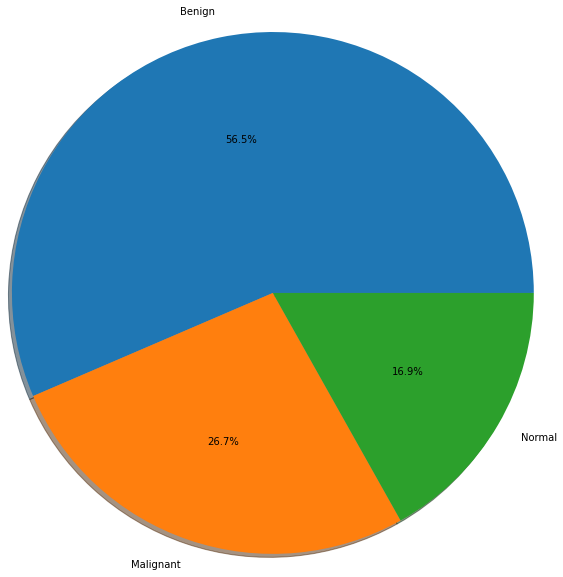

In [106]:
# Let us first analyze the distribution of the target variable
target = 'label'
labels = ['Benign','Malignant','Normal']
features = [i for i in data.columns.values if i not in [target]]
MAP={}
for e, i in enumerate(data[target].value_counts().index):
    MAP[i]=labels[e]
data[target]=data[target].map(MAP)
explode=np.zeros(len(data[target].value_counts()))
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(data[target].value_counts(), labels=data[target].value_counts().index, counterclock=True, shadow=True, 
        explode=explode, autopct='%.1f%%', radius=1.5, startangle=0)
plt.show()

                                     Features Distribution                                      


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

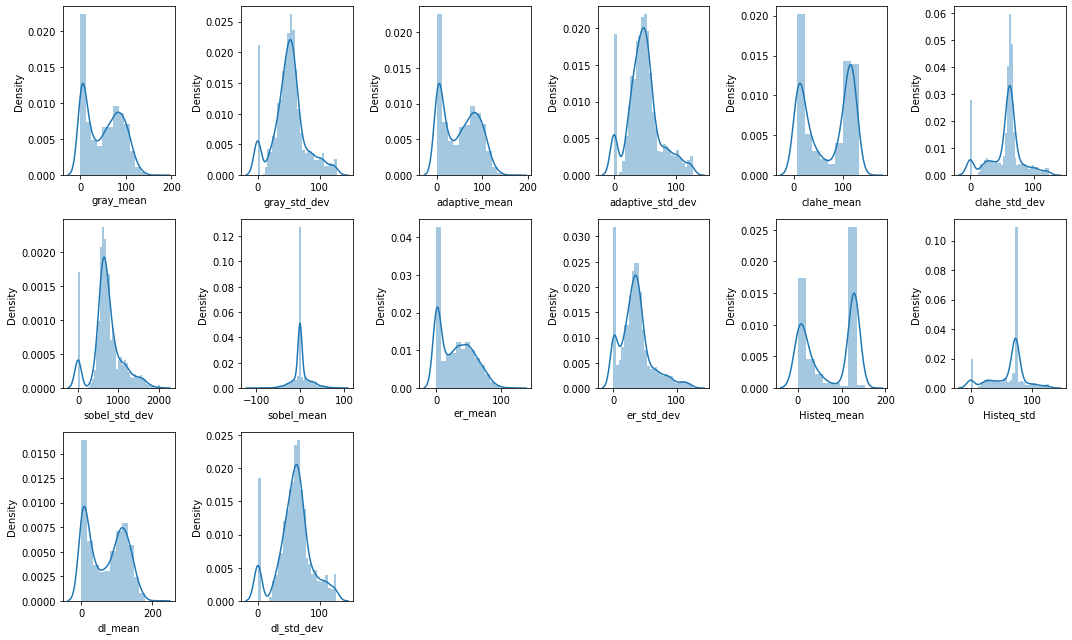

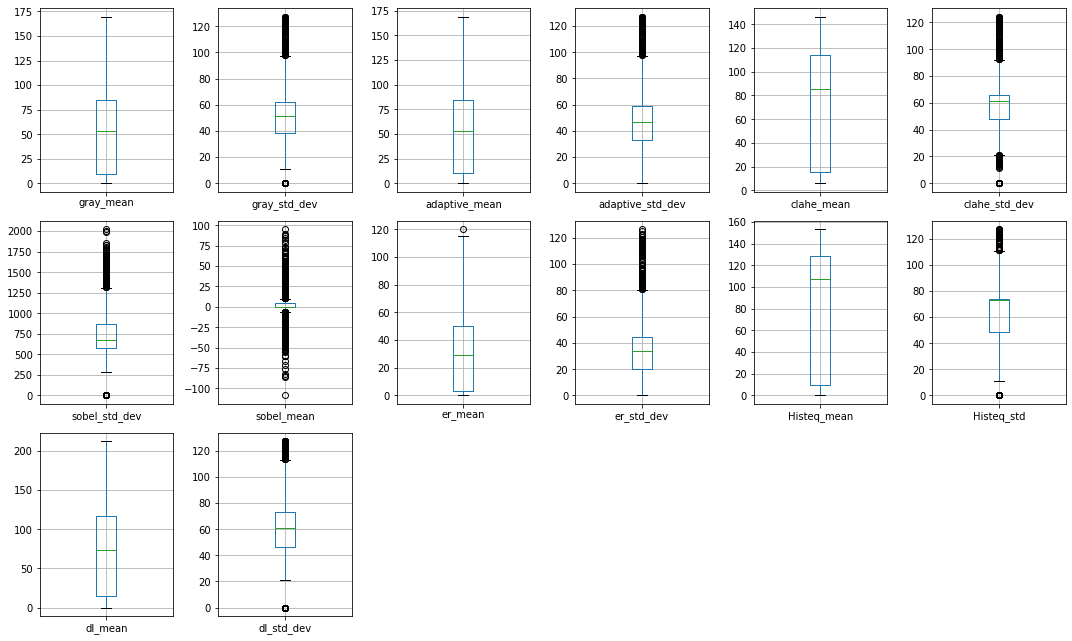

In [107]:
import math
print('\033[1mFeatures Distribution'.center(100))
cf = []
#Checking number of unique rows in each feature

nu = data[features].nunique().sort_values()
nf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(data[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])
for i in range(data[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])
n=6
nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/n),n,c+1)
    sns.distplot(data[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/n),n,c+1)
    data.boxplot(nf[c])
plt.tight_layout()
plt.show()

In [108]:
#Check for empty elements
nvc = pd.DataFrame(data.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/data.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
gray_mean                         0         0.0
gray_std_dev                      0         0.0
adaptive_mean                     0         0.0
adaptive_std_dev                  0         0.0
clahe_mean                        0         0.0
clahe_std_dev                     0         0.0
sobel_std_dev                     0         0.0
sobel_mean                        0         0.0
er_mean                           0         0.0
er_std_dev                        0         0.0
Histeq_mean                       0         0.0
Histeq_std                        0         0.0
dl_mean                           0         0.0
dl_std_dev                        0         0.0
label                             0         0.0


In [109]:
'''# Removal of outlier:
data2 = data1.copy()

for i in [i for i in data2.columns]:
    if data2[i].nunique()>=12:
        Q1 = data2[i].quantile(0.15)
        Q3 = data2[i].quantile(0.85)
        IQR = Q3 - Q1
        data2 = data2[data2[i] <= (Q3+(1.5*IQR))]
        data2 = data2[data2[i] >= (Q1-(1.5*IQR))]
data2 = data2.reset_index(drop=True)
display(data2.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(data1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(data2.shape[0]))'''

"# Removal of outlier:\ndata2 = data1.copy()\n\nfor i in [i for i in data2.columns]:\n    if data2[i].nunique()>=12:\n        Q1 = data2[i].quantile(0.15)\n        Q3 = data2[i].quantile(0.85)\n        IQR = Q3 - Q1\n        data2 = data2[data2[i] <= (Q3+(1.5*IQR))]\n        data2 = data2[data2[i] >= (Q1-(1.5*IQR))]\ndata2 = data2.reset_index(drop=True)\ndisplay(data2.head())\nprint('\n\x1bInference:\x1b Before removal of outliers, The dataset had {} samples.'.format(data1.shape[0]))\nprint('\x1bInference:\x1b After removal of outliers, The dataset now has {} samples.'.format(data2.shape[0]))"

In [110]:
from sklearn.model_selection import train_test_split

X = data.drop([target], axis=1)
Y = data[target]
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0, shuffle=True)

print('Original set  ---> ', X.shape, Y.shape)
print('Training set  ---> ', x_train.shape, y_train.shape)
print('Testing set   ---> ', x_test.shape, y_test.shape)


Original set  --->  (1578, 14) (1578,)
Training set  --->  (1262, 14) (1262,)
Testing set   --->  (316, 14) (316,)


In [111]:
#Splitting the data intro training & testing sets

X = data.drop([target],axis=1)
Y = data[target]
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',x_train.shape,y_train.shape,'\nTesting set   ---> ', x_test.shape,'', y_test.shape)

Original set  --->  (1578, 14) (1578,) 
Training set  --->  (1262, 14) (1262,) 
Testing set   --->  (316, 14)  (316,)


In [112]:
# Feature Scaling (Standardization)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
std = StandardScaler()
print('\033[1mStandardardization on Training set'.center(100))
x_train = std.fit_transform(x_train)
X_train = pd.DataFrame(x_train, columns=X.columns)
display(X_train.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
x_test = std.transform(x_test)
X_test = pd.DataFrame(x_test, columns=X.columns)
display(X_test.describe())

                               Standardardization on Training set                               


,gray_mean,gray_std_dev,adaptive_mean,adaptive_std_dev,clahe_mean,clahe_std_dev,sobel_std_dev,sobel_mean,er_mean,er_std_dev,Histeq_mean,Histeq_std,dl_mean,dl_std_dev
count,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03
mean,-8.163922e-17,-1.477951e-16,2.111359e-17,1.119020e-16,4.081961e-17,-7.952786e-17,-5.278398e-17,9.853009e-18,4.644990e-17,-5.911806e-17,3.659689e-17,1.273853e-16,9.289980e-17,-8.023165e-17
std,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00
min,-1.289749e+00,-1.901482e+00,-1.290263e+00,-1.766463e+00,-1.301081e+00,-2.120469e+00,-1.979447e+00,-5.584566e+00,-1.164464e+00,-1.384759e+00,-1.266679e+00,-2.170209e+00,-1.301653e+00,-2.115771e+00
25%,-1.049159e+00,-4.863639e-01,-1.048581e+00,-5.536757e-01,-1.104357e+00,-3.459731e-01,-4.104312e-01,-1.177723e-01,-1.053154e+00,-6.022173e-01,-1.104502e+00,-4.958100e-01,-1.046667e+00,-4.680017e-01
50%,4.962214e-02,-2.248307e-03,5.161980e-02,-6.709863e-02,3.463225e-01,1.835564e-01,-1.217063e-01,-1.177723e-01,-5.346491e-02,-7.822795e-02,3.646485e-01,4.002898e-01,1.726677e-02,6.051310e-02
75%,8.748043e-01,3.924148e-01,8.718120e-01,3.748382e-01,9.761094e-01,3.501576e-01,3.943807e-01,9.874259e-02,7.858182e-01,3.418656e-01,9.731062e-01,4.119399e-01,9.055300e-01,4.652140e-01
max,2.996468e+00,2.799610e+00,3.002076e+00,2.865723e+00,1.662776e+00,2.567363e+00,3.538780e+00,4.396421e+00,3.464225e+00,3.562892e+00,1.254315e+00,2.302947e+00,2.688458e+00,2.412646e+00



                                Standardardization on Testing set                                


,gray_mean,gray_std_dev,adaptive_mean,adaptive_std_dev,clahe_mean,clahe_std_dev,sobel_std_dev,sobel_mean,er_mean,er_std_dev,Histeq_mean,Histeq_std,dl_mean,dl_std_dev
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,0.016978,0.021031,0.016827,0.012582,0.038430,0.051902,0.001368,-0.047039,0.001174,-0.010744,0.062103,0.046790,0.025370,0.033725
std,0.975995,0.882101,0.976085,0.895743,0.984481,0.870275,0.844144,0.937033,0.981810,0.908290,1.000668,0.875679,0.975050,0.875329
min,-1.289749,-1.901482,-1.290263,-1.766463,-1.301081,-2.120469,-1.979447,-3.163996,-1.164464,-1.384759,-1.266679,-2.170209,-1.301653,-2.115771
25%,-0.943902,-0.458747,-0.942835,-0.566458,-1.018353,-0.034957,-0.406159,-0.204645,-0.971081,-0.586921,-1.032458,-0.185322,-0.938032,-0.444546
50%,0.126554,0.051346,0.126736,-0.019256,0.446352,0.204675,-0.140346,-0.117772,-0.048989,-0.060633,0.956299,0.399261,0.200430,0.079094
75%,0.799969,0.405553,0.801825,0.408153,0.959019,0.370653,0.380084,0.019485,0.709095,0.359968,0.974379,0.411506,0.862407,0.504192
max,2.174003,2.792072,2.182555,2.859952,1.286854,2.559819,3.009395,4.678691,2.681350,3.414785,1.413456,2.290053,1.947977,2.413009


In [113]:
data.groupby(['label']).count()

,gray_mean,gray_std_dev,adaptive_mean,adaptive_std_dev,clahe_mean,clahe_std_dev,sobel_std_dev,sobel_mean,er_mean,er_std_dev,Histeq_mean,Histeq_std,dl_mean,dl_std_dev
label,,,,,,,,,,,,,,
Benign,891,891,891,891,891,891,891,891,891,891,891,891,891,891
Malignant,421,421,421,421,421,421,421,421,421,421,421,421,421,421
Normal,266,266,266,266,266,266,266,266,266,266,266,266,266,266


Test Accuracy Score of Basic Logistics Regression: 89.24


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      Benign       1.00      0.91      0.95       181
   Malignant       0.76      0.97      0.85       100
      Normal       0.83      0.57      0.68        35

    accuracy                           0.89       316
   macro avg       0.87      0.82      0.83       316
weighted avg       0.91      0.89      0.89       316



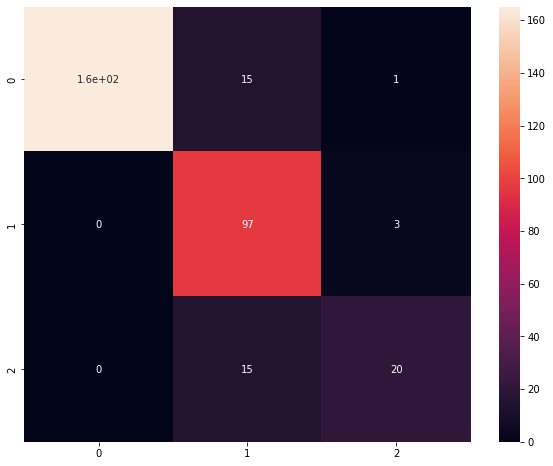

In [114]:
## Applying Logistic Regression Algorithm 
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(random_state=0)
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_test)
test_accuracy1 = round(accuracy_score(y_test, y_pred1) * 100, 2)
print('Test Accuracy Score of Basic Logistics Regression:',test_accuracy1)
conf1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(conf1, annot=True)
print(classification_report(y_test,y_pred1))

Test Accuracy Random Forest is : 86.70886075949366 %
              precision    recall  f1-score   support

      Benign       0.92      0.94      0.93       181
   Malignant       0.80      0.79      0.79       100
      Normal       0.78      0.71      0.75        35

    accuracy                           0.87       316
   macro avg       0.83      0.81      0.82       316
weighted avg       0.87      0.87      0.87       316



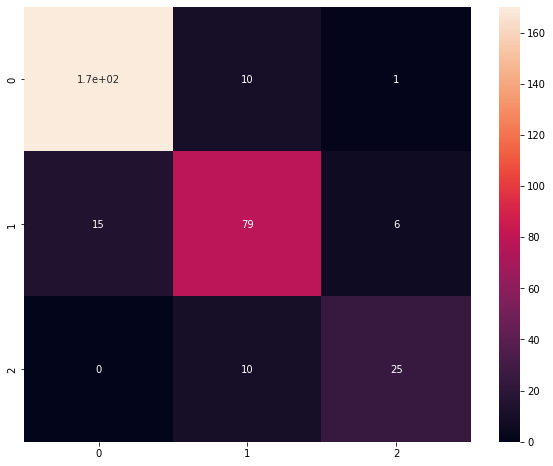

In [115]:
## Applying Random Forest Algorithm
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators =100)
model.fit(x_train,y_train)
y_pred2 = model.predict(x_test)
print("Test Accuracy Random Forest is :",accuracy_score(y_pred2,y_test)*100,'%')
conf2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(conf2, annot=True)
print(classification_report(y_test,y_pred2))

Test Accuracy Score of KNN: 89.24
              precision    recall  f1-score   support

      Benign       0.97      0.93      0.95       181
   Malignant       0.80      0.88      0.84       100
      Normal       0.79      0.74      0.76        35

    accuracy                           0.89       316
   macro avg       0.85      0.85      0.85       316
weighted avg       0.90      0.89      0.89       316



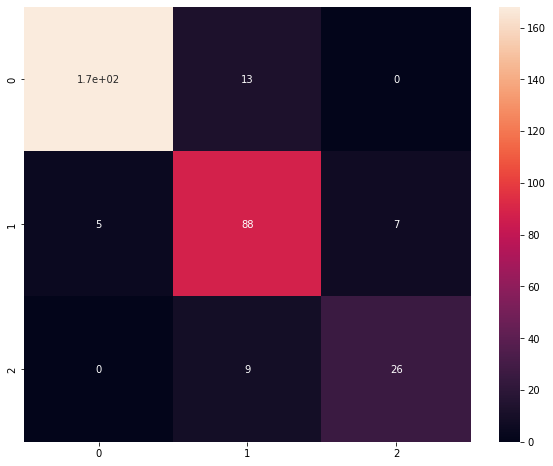

In [116]:
## Applying KNN Algorithm 
from sklearn.neighbors import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=13 , metric= 'minkowski' , p = 4, weights= 'uniform')
model3.fit(x_train,y_train)
y_pred3 = model3.predict(x_test)
test_accuracy3 = round(accuracy_score(y_test, y_pred3) * 100, 2)
print('Test Accuracy Score of KNN:',test_accuracy3)
conf3 = confusion_matrix(y_test, y_pred3)
sns.heatmap(conf3, annot=True)
print(classification_report(y_test,y_pred3))

In [117]:
#HyperParameter Tuning for SVM
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

  
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

# fitting the model for grid search
gs.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [118]:
# find the best score
print(gs.best_score_)
# get the hyperparameters with the best score
print(gs.best_params_)

0.8486596538853072
{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}


Test Accuracy Score of SVM : 90.19
              precision    recall  f1-score   support

      Benign       1.00      0.91      0.95       181
   Malignant       0.80      0.95      0.87       100
      Normal       0.79      0.74      0.76        35

    accuracy                           0.90       316
   macro avg       0.86      0.87      0.86       316
weighted avg       0.91      0.90      0.90       316



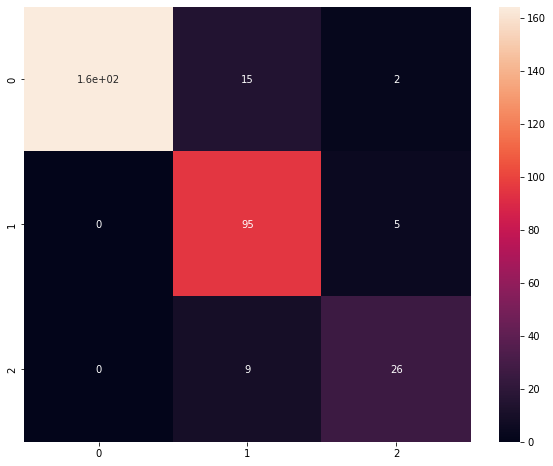

In [119]:
from sklearn.svm import SVC, LinearSVC
model4 = SVC(C=1000, gamma=0.01)
model4.fit(x_train,y_train)
y_pred4 = model4.predict(x_test)
test_accuracy4 = round(accuracy_score(y_test, y_pred4) * 100, 2)
print('Test Accuracy Score of SVM :',test_accuracy4)
conf4 = confusion_matrix(y_test, y_pred4)
sns.heatmap(conf4, annot=True)
print(classification_report(y_test,y_pred4))

In [120]:
#HyperParameter Tuning for SVM
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.810 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.802 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.825 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.802 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.826 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.850 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.841 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.829 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.814 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [121]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.01)


Test Accuracy Score of Decision Tree is : 83.23
              precision    recall  f1-score   support

      Benign       0.88      0.94      0.91       181
   Malignant       0.78      0.69      0.73       100
      Normal       0.71      0.69      0.70        35

    accuracy                           0.83       316
   macro avg       0.79      0.77      0.78       316
weighted avg       0.83      0.83      0.83       316



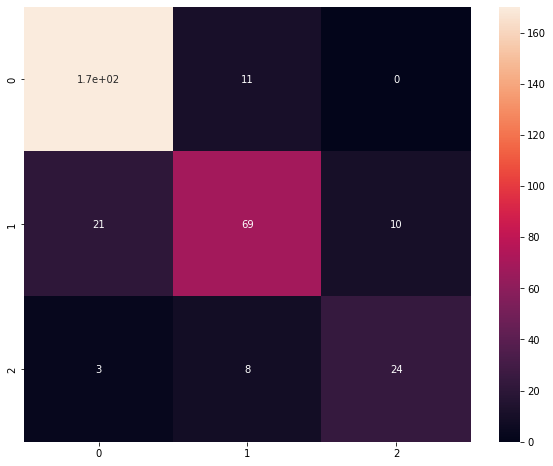

In [122]:
from sklearn.tree import DecisionTreeClassifier
model5 = DecisionTreeClassifier()
model5.fit(x_train,y_train)
y_pred5 = model5.predict(x_test)
test_accuracy5 = round(accuracy_score(y_test, y_pred5) * 100, 2)
print('Test Accuracy Score of Decision Tree is :',test_accuracy5)
conf5 = confusion_matrix(y_test, y_pred5)
sns.heatmap(conf5, annot=True)
print(classification_report(y_test,y_pred5))

Test Accuracy Score of Naive Bayes: 80.06
              precision    recall  f1-score   support

      Benign       0.99      0.91      0.95       181
   Malignant       0.73      0.71      0.72       100
      Normal       0.32      0.49      0.39        35

    accuracy                           0.80       316
   macro avg       0.68      0.70      0.69       316
weighted avg       0.84      0.80      0.82       316



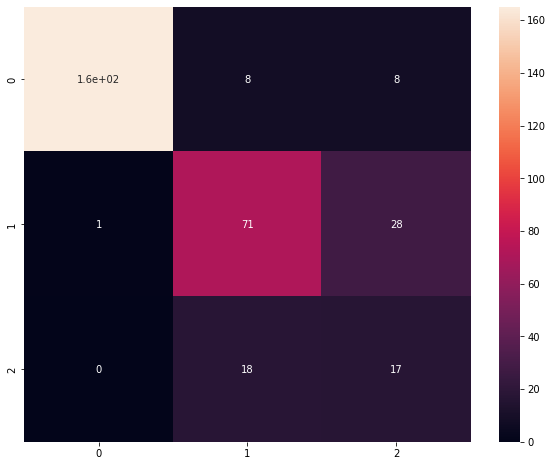

In [123]:
## Applying Naive Bayes Algorithm
from sklearn.naive_bayes import GaussianNB
model6 = GaussianNB()
model6.fit(x_train,y_train)
y_pred6 = model6.predict(x_test)
test_accuracy6 = round(accuracy_score(y_test, y_pred6) * 100, 2)
print('Test Accuracy Score of Naive Bayes:',test_accuracy6)
conf6 = confusion_matrix(y_test, y_pred6)
sns.heatmap(conf6, annot=True)
print(classification_report(y_test,y_pred6))

In [124]:
##============================================THE END=========================================##